In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [ ]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !nvidia-smi
    TF_CPP_MIN_LOG_LEVEL=2

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # get data
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')


Running on CoLab
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



SystemError: ignored

In [ ]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def plot_distribution_error(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
    sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
    sns.distplot(a=train_y.flatten(), ax=ax1, label= 'True')
    sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
    sns.distplot(a=test_y.flatten(), ax=ax2, label='True')
    plt.legend()
    plt.tight_layout()

def get_errors(model, train_X, test_X, train_y, test_y):
    
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    mse_test = mean_squared_error(test_y, test_predictions)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(test_y, test_predictions)
    
    MAE_train = abs(train_predictions - train_y).mean()
    MAE_test = abs(test_predictions - test_y).mean()
    if train_y.shape[1] == 3:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1))
    else:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1,2))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1,2))
    
    return MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test

def plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test):
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,4))
    fig.suptitle('MAE Overall', y=1.02, fontsize=13.5)
    
    ax1.plot(mae_overall_train, label='MAE Train')
    ax1.set_title('MAE Train={}'.format(MAE_train))
    ax2.plot(mae_overall_test, label='MAE Test', color='teal')
    ax2.set_title('MAE Test={}'.format(MAE_test))
    fig.legend(loc='upper right')
    plt.tight_layout()

def plot_lstm(model, X, y, feature_index=0):

    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1),
                                                     y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse_test)
    r2 = r2_score(y, prediction)

    fig, ax1 = plt.subplots(1,1,figsize=(14,4))
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth rmse = {}, r2 score = {}'.format(np.round(rmse,4), np.round(r2,4)))    
    plt.tight_layout()
    
def plot_predictions(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    data_final = dict(train_pred=train_predictions, train_true=train_y,
                      test_pred=test_predictions, test_true=test_y)

    # Number of time steps in the future, as increases the accuracy decreases
    ith_timestep = 7

    for lb in ['train', 'test']:   
        fig, axx = plt.subplots(3,1,figsize=(18,9))
        for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
            axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
            axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
            axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
        fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
        plt.tight_layout()

def train_model(model, train_X, train_y, callbacks, epochs=100, batch_size=256, patience=5, verbose=1, validation_split=0.25):

  if verbose==0:
    print('Training model')
  history = model.fit(train_X, train_y,
                      validation_split=validation_split, 
                      epochs=epochs, verbose=verbose,
                      callbacks=[callbacks], 
                      batch_size=batch_size)
  return history

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, mae=0.03):
    super(myCallback, self).__init__()
    self.mae = mae

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') <= self.mae):
      print("\nReached 0.03 mae so cancelling training!")
      self.model.stop_training = True

In [ ]:
### MODELS

def Model_recurrent(units, input_shape, dropout=0.2, LSTM=True):

  model = tf.keras.models.Sequential()

  if LSTM==False:
    model.add(tf.keras.layers.GRU(units=units, dropout=0.2, return_sequences=True, input_shape=input_shape)) 
    model.add(tf.keras.layers.GRU(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
  else:
    model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=True, dropout=dropout))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=False,
                                   dropout=dropout))
    
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

def model_dnn(units, input_shape, dropout=0.2)
  model = Sequential()
  #model.add(tf.keras.layers.Reshape(input_shape, input_shape=(input_shape,)))
  model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=input_shape))
  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=num_classes))

def Model_cnn(input_shape, units=128, filters=64, kernel_size=3, dropout=0.2, LSTM=False):

  model = tf.keras.models.Sequential()

  if LSTM==False:
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape,
                                     activation='relu')) 
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
  else:
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape,
                                     activation='relu'))
    model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
    #model.add(tf.keras.layers.LSTM(units=units, return_sequences=False,
    #                               dropout=dropout))
    
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

def Model_Seq(n_hidden, input_shape, output_shape, dropout):

  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

  encoder_last_h1, encoder_last_h2, encoder_last_c = \
  tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                       return_sequences=False,
                       return_state=True)(input_train)

  # Batch normalisation is added because we want to avoid gradient
  # explosion caused by the activation function ELU in the encoder.
  #encoder_last_h1 = BatchNormalization(momentum=0.9)(encoder_last_h1)
  #encoder_last_c = BatchNormalization(momentum=0.9)(encoder_last_c)

  # Create copies of las hidden state
  decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

  # nitial_state: List of initial state tensors to be passed to the first call of the cell 
  #(optional, defaults to None which causes creation of zero-filled initial state tensors).
  # In this case initial state is the output from encoder
  decoder = tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                                return_state=False,
                                return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

  out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
  model = tf.keras.Model(inputs=input_train, outputs=out)
  return model

SyntaxError: ignored

Lenght of Data 14688
Lenght of Train 11750


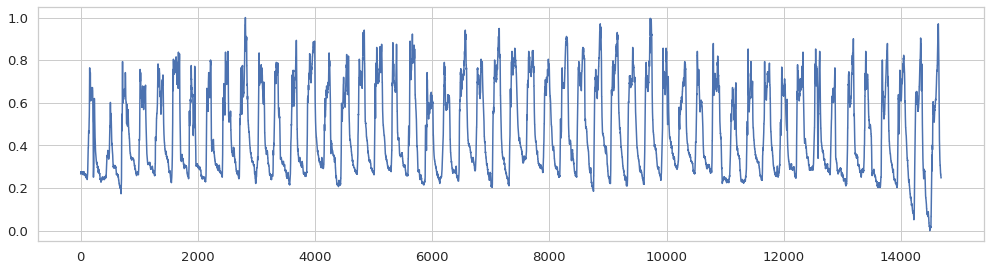

In [ ]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

fig, ax1 = plt.subplots(1,1, figsize=(14,4))
ax1.plot(normalized_train[:,0])
plt.tight_layout()

# LSTM


Training model
Mean Absolute Error in Testing  0.044480795255802064
Mean Squared Error in Testing  0.004583890634024147
R2 Score in Testing  0.9500707626270021
Root Mean Squared Error in Testing  0.06770443585190078


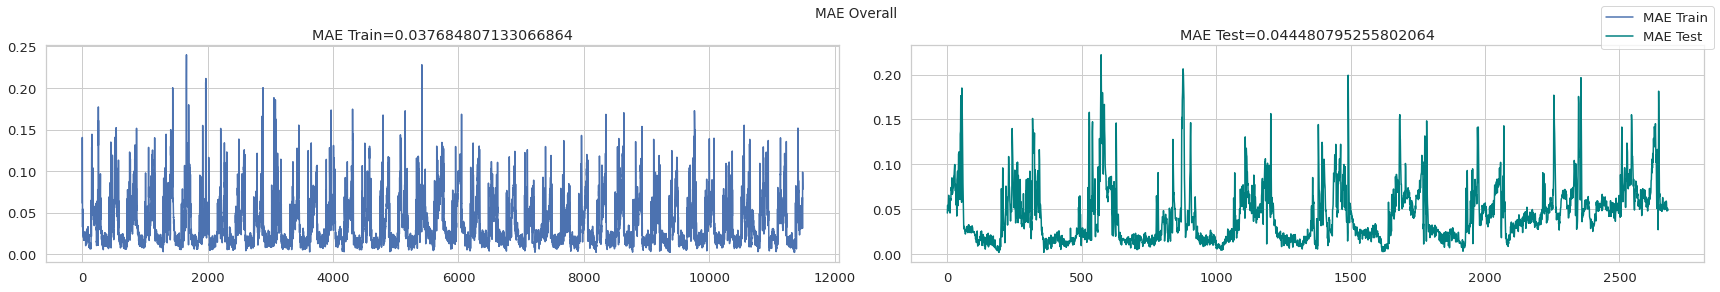

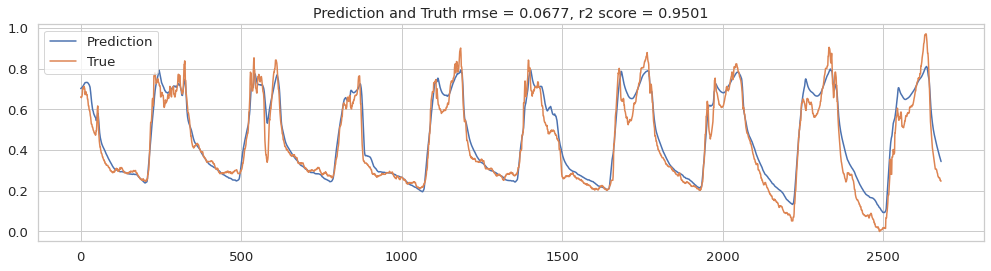

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_lstm = Model_recurrent(units=n_hidden, input_shape=(n_timesteps_in, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_lstm = train_model(model_lstm, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_lstm_df = pd.DataFrame(history_lstm.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_lstm, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

plot_lstm(model_lstm, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# GRU

Training model
Mean Absolute Error in Testing  0.07505509939699626
Mean Squared Error in Testing  0.01336713322300738
R2 Score in Testing  0.8946430595663605
Root Mean Squared Error in Testing  0.11561631901685583


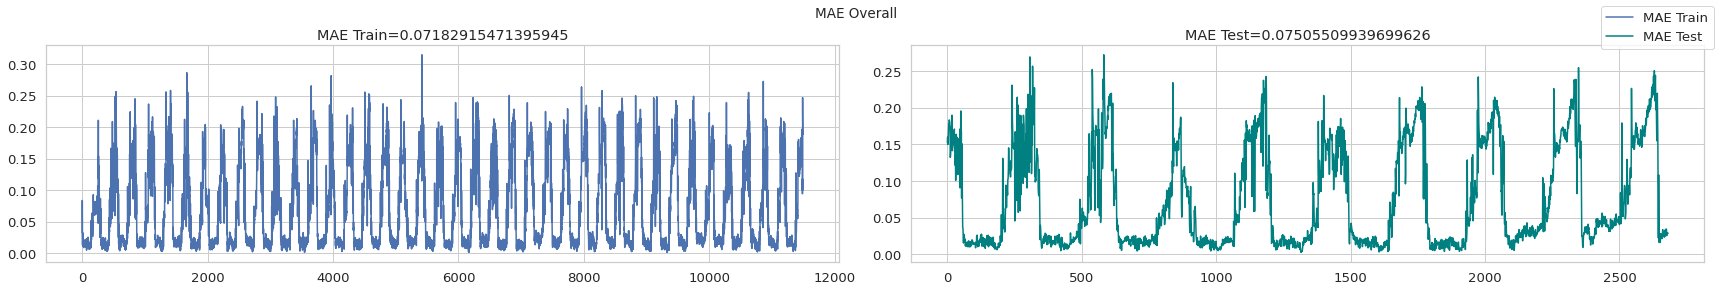

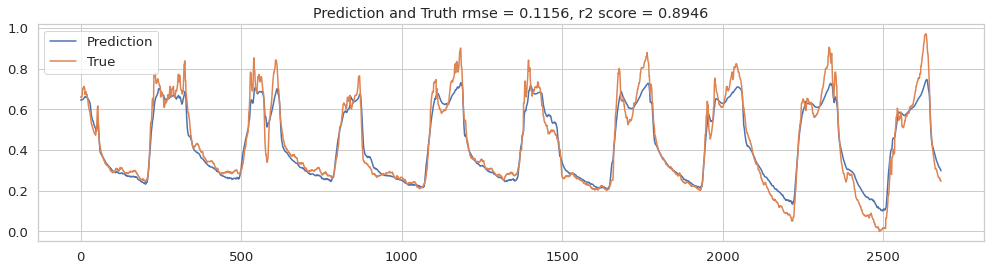

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_gru = Model_recurrent(units=n_hidden, input_shape=(n_timesteps_in, n_features),
                            dropout=0.2, LSTM=False)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_gru.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_gru = train_model(model_gru, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_cnn_df = pd.DataFrame(history_gru.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_gru, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

plot_lstm(model_gru, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# CNN

Training model
Mean Absolute Error in Testing  0.09687561124956529
Mean Squared Error in Testing  0.015498438060024438
R2 Score in Testing  0.8480115776232694
Root Mean Squared Error in Testing  0.12449272291995399


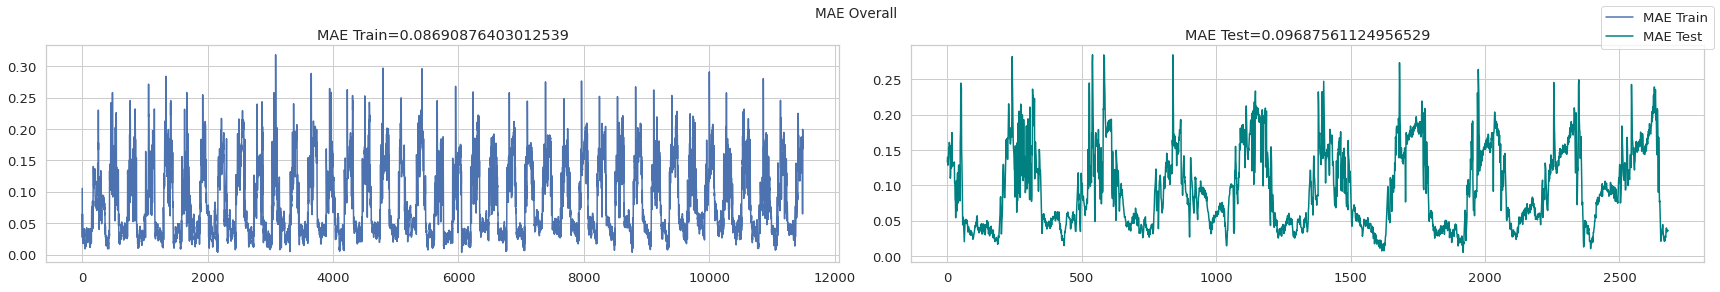

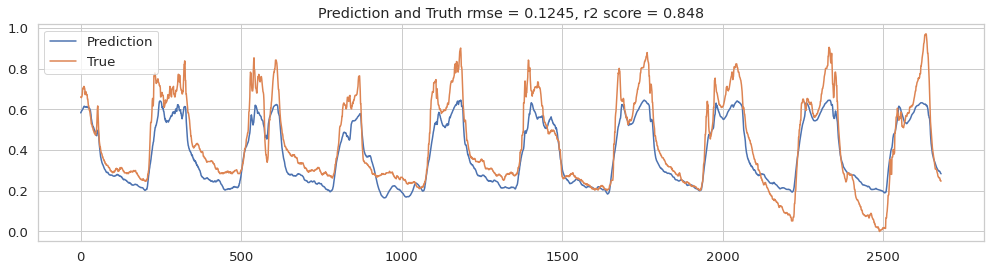

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_cnn = Model_cnn(input_shape=(n_timesteps_in, n_features), filters=64,
                      kernel_size=3, dropout=0.2, LSTM=False)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_cnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_cnn = train_model(model_cnn, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_cnn_df = pd.DataFrame(history_cnn.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_cnn, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

plot_lstm(model_cnn, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# LSTM+CNN

Training model
Mean Absolute Error in Testing  0.02818265762511527
Mean Squared Error in Testing  0.0023514107780479607
R2 Score in Testing  0.9715903776557607
Root Mean Squared Error in Testing  0.0484913474554787


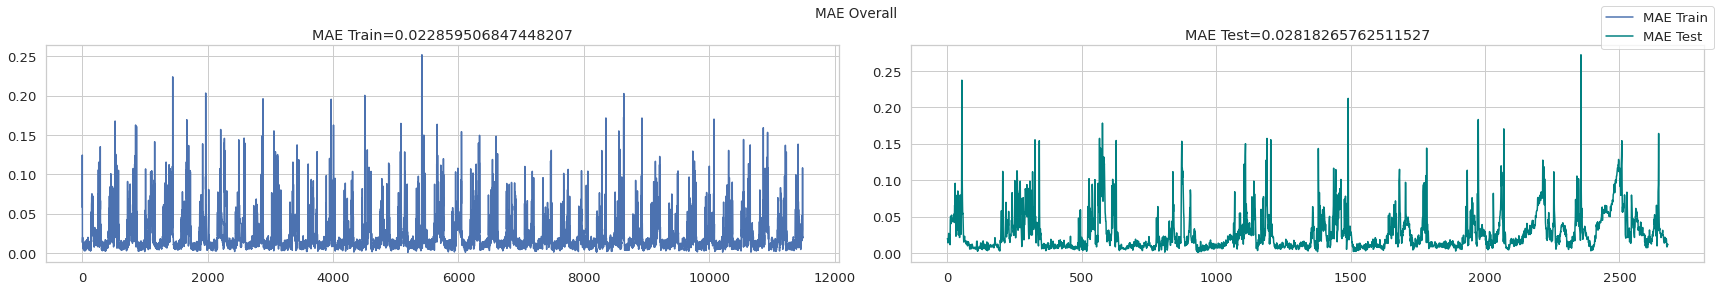

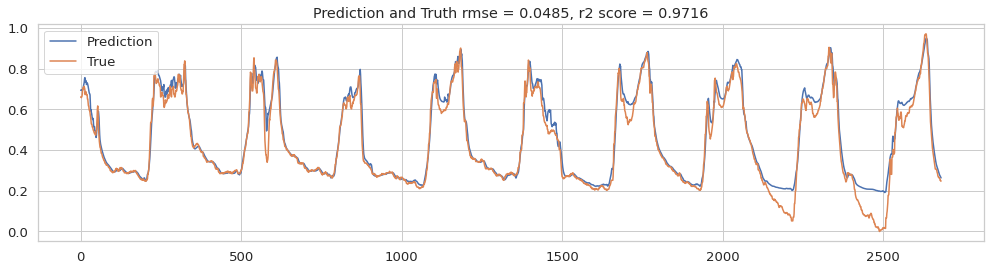

In [ ]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_lstm_cnn = Model_cnn(input_shape=(n_timesteps_in, n_features), filters=64,
                      kernel_size=3, dropout=0.2, LSTM=True)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_lstm_cnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_lstm_cnn = train_model(model_lstm_cnn, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_lstm_cnn_df = pd.DataFrame(history_lstm_cnn.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_lstm_cnn, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test)

plot_lstm(model_lstm_cnn, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# DNN

# Seq to Seq